Epoch 1/10 - Loss: 1.4188, Acc: 49.04%
Epoch 2/10 - Loss: 1.0797, Acc: 61.80%
Epoch 3/10 - Loss: 0.9414, Acc: 66.78%
Epoch 4/10 - Loss: 0.8497, Acc: 70.20%
Epoch 5/10 - Loss: 0.7740, Acc: 72.78%
Epoch 6/10 - Loss: 0.7106, Acc: 75.02%
Epoch 7/10 - Loss: 0.6477, Acc: 77.16%
Epoch 8/10 - Loss: 0.5874, Acc: 79.26%
Epoch 9/10 - Loss: 0.5377, Acc: 80.95%
Epoch 10/10 - Loss: 0.4819, Acc: 82.86%


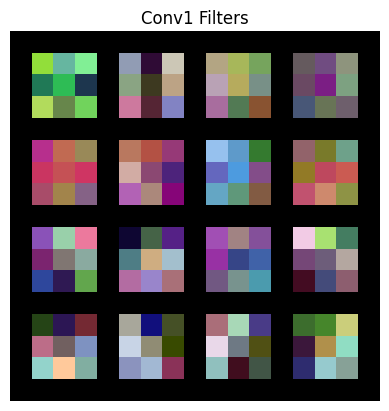


🧪 Test Accuracy: 70.04%


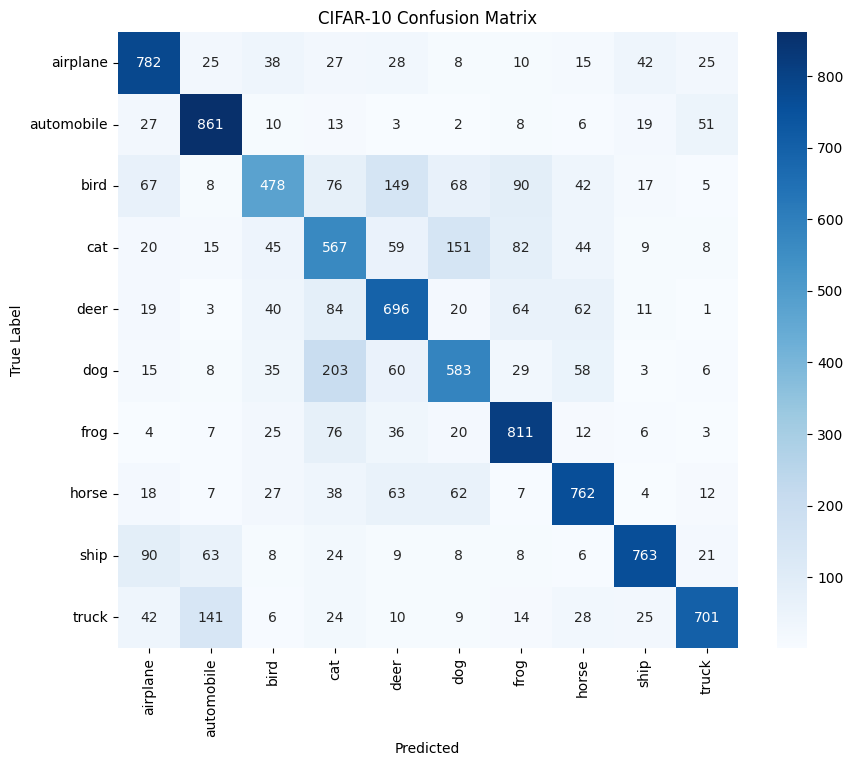

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Define CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),  # 32x32
            nn.ReLU(),
            nn.MaxPool2d(2),                # 16x16
            nn.Conv2d(16, 32, 3, padding=1),# 16x16
            nn.ReLU(),
            nn.MaxPool2d(2)                 # 8x8
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*8*8, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

# Train the model
def train(model, loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss/len(loader):.4f}, Acc: {100*correct/total:.2f}%")

# Visualize filters
def visualize_filters(model):
    with torch.no_grad():
        weights = model.conv[0].weight.cpu()
        grid = torchvision.utils.make_grid(weights, nrow=4, normalize=True, padding=1)
        plt.imshow(grid.permute(1, 2, 0))
        plt.title("Conv1 Filters")
        plt.axis('off')
        plt.show()

# Run everything
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train(model, trainloader, criterion, optimizer, epochs=10)
visualize_filters(model)
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import torch

# CIFAR-10 class names
classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    return acc, cm

# Evaluate
test_acc, test_cm = evaluate_model(model, testloader, device)
print(f"\n Test Accuracy: {test_acc*100:.2f}%")

#Confusion Matrix Visualization
plt.figure(figsize=(10, 8))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True Label")
plt.title("CIFAR-10 Confusion Matrix")
plt.show()


In [4]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Pick 100 test images to animate
def get_test_samples(test_loader, num_samples=100):
    images, labels = [], []
    for batch_images, batch_labels in test_loader:
        for img, lbl in zip(batch_images, batch_labels):
            images.append(img)
            labels.append(lbl)
            if len(images) >= num_samples:
                return images, labels
    return images, labels

# Run predictions on selected test samples
def get_predictions(model, images, device):
    preds = []
    model.eval()
    with torch.no_grad():
        for img in images:
            img_batch = img.unsqueeze(0).to(device)
            output = model(img_batch)
            pred = torch.argmax(output, dim=1).item()
            preds.append(pred)
    return preds

# Animate predictions
def animate_predictions(images, labels, preds, class_names):
    fig, ax = plt.subplots(figsize=(3, 3))
    img_display = ax.imshow(np.transpose(images[0].numpy(), (1, 2, 0)))
    title = ax.set_title("", fontsize=12)
    ax.axis('off')

    def update(i):
        img = np.transpose(images[i].numpy(), (1, 2, 0))
        img_display.set_data(img)
        pred_label = class_names[preds[i]]
        true_label = class_names[labels[i]]
        color = "green" if preds[i] == labels[i] else "red"
        title.set_text(f"Pred: {pred_label} | True: {true_label}")
        title.set_color(color)
        return img_display, title

    ani = animation.FuncAnimation(fig, update, frames=len(images), interval=800, blit=False)
    plt.close()
    return ani

#Execute
test_images, test_labels = get_test_samples(testloader, 100)
test_preds = get_predictions(model, test_images, device)
ani = animate_predictions(test_images, test_labels, test_preds, classes)
ani.save("cifar10_predictions.mp4", writer='ffmpeg', fps=1)

#Display animation
HTML(ani.to_jshtml())
